In [59]:
include("speciale_tools.jl")
import JLD
import PyPlot

In [60]:
data_folder = "/home/data/simon/processed/test_areas/vejle_new/flood"
figure_folder = "/home/data/simon/result/HSBA_vejle"

VV = [JLD.load(joinpath(data_folder,"VV_co.jld"),"data"),
    JLD.load(joinpath(data_folder,"VV_pre_median.jld"),"data")]


VH = [JLD.load(joinpath(data_folder,"VH_co.jld"),"data"), 
    JLD.load(joinpath(data_folder,"VH_pre_median.jld"),"data")];


In [61]:
threshold_indx = 3

3

## VV

In [70]:
co = VV[1][:,end:-1:1]
pre = VV[2][:,end:-1:1];

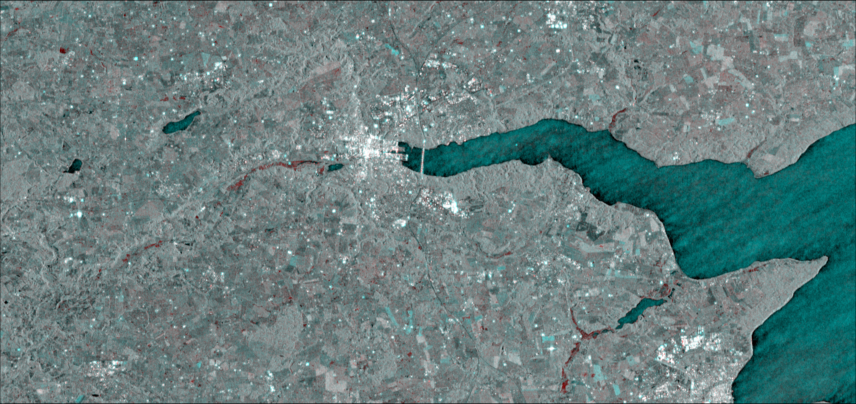

In [71]:
imgVV = pretty_img([co,pre],min_vv,max_vv)

In [72]:
flood_band = 10 .*log10.(co);
ref_band = 10 .*log10.(pre);
change_band = flood_band .- ref_band;

In [73]:
# Find the tiles to fit bimodal
bm_mask_flood = find_bimodal_tiles(flood_band);
bm_mask_change = find_bimodal_tiles(change_band);
bm_mask = bm_mask_change.&bm_mask_flood;


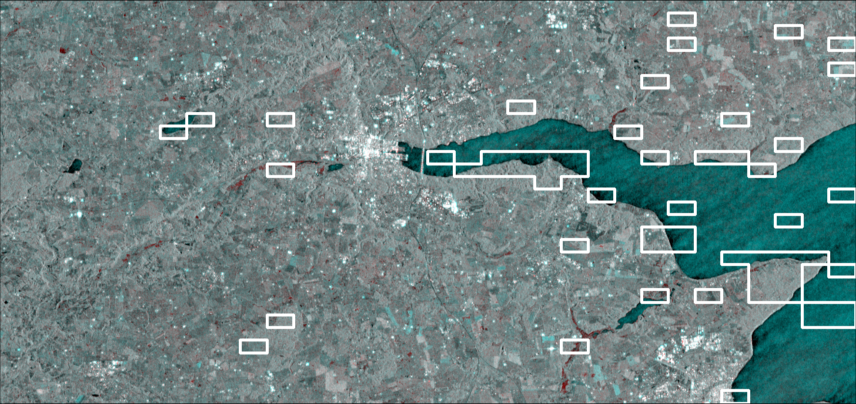

In [74]:
subset_edges = get_edges(bm_mask);
img_save = add_mask(imgVV,subset_edges,(1,1,1))

file_path = joinpath(figure_folder,"VV_tile_select_median")
FileIO.save(file_path*".png",img_save)
img_save

In [75]:
# fit bimodel
data = reshape(flood_band,:)[reshape(bm_mask,:)]
p_fit,y,w,edges, w_sum = fit_bimodal_gauss(data,round(Int64,length(data)/50))

# Find seed pixels
y_seed =find_y_seed(p_fit,y)
seed_mask = flood_band .<y_seed;


In [11]:
t_0 = [y_seed+1, -1]
thresholds3, n_iter = grad_decent(
            (t1,t2) -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [t1,t2])
            ,t_0,debug=true)
f3 = sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds3);


Iterration : 1
x_i: [-11.45, -1.0], f_i: 0.0004742552131801876
dfdx: [-0.00023652799912145071, 0.0]
Step x, step_idx:4,  no_step: -2

Iterration : 2
x_i: [12.202799912145071, -1.0], f_i: 0.00046012781005705416
dfdx: [0.0, -2.184860867465547e-5]
Max Iter reached:  region_growing()
Step x, step_idx:4,  no_step: -2
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()

Iterration : 3
x_i: [12.202799912145071, 1.184860867465547], f_i: 0.00016302152162315375
dfdx: [0.0, -2.6796363806301096e-5]
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Step x, step_idx:1,  no_step: -2
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()

Iterration : 4
x_i: [12.202799912145071, 1.187540503846177], f_i: 0.00016292012252276748
dfdx: [0.0, -1.551099997852459e-5]
Max I

In [12]:
thresholds3, f3

([12.202799912145071, 1.187540503846177], 0.00016292012252276748)

In [13]:
t_0 = [y_seed+1, -1]
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, t), 
    t_0; autodiff = :forward,store_trace = true,trace_simplex=true)
thresholds1 = res.minimizer
f1 = sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds1)
thresholds1, f1

Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()


([2.255688095092774, 1.2955283164978026], 0.00016259185314493397)

In [14]:
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [t,10]),
    y_seed, p_fit[4])

y_RG = res.minimizer
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [y_RG,t]),
    -5, 2)
thresholds2 = [y_RG, res.minimizer]
f2 = sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds2)
thresholds2, f2

([-9.830814166603682, 1.996669124853917], 0.00016887723334814612)

In [15]:
rg_thresholds = [thresholds1,thresholds2,thresholds3][threshold_indx];

In [16]:
folder_names_path = joinpath(figure_folder,"thresholds_parameters_VV.txt")   
open(folder_names_path, "w") do io
    write(io, "opt_mul, $(thresholds1[1]), $(thresholds1[2]), $f1 \n")
    write(io, "opt_uni, $(thresholds2[1]), $(thresholds2[2]), $f2 \n")
    write(io, "opt_own, $(thresholds3[1]), $(thresholds3[2]), $f3 \n")
end;

In [17]:
test_sigma = collect(LinRange(y_seed,-8,20))
test_dsigma = collect(LinRange(-2,3,20))
@time loss = [sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [r1,r2])
    for r1=test_sigma, r2=test_dsigma];

381.862079 seconds (14.04 M allocations: 33.769 GiB, 0.14% gc time)


In [18]:
minimum(loss),maximum(loss)

(0.0001581688620114912, 0.00048430675375895867)

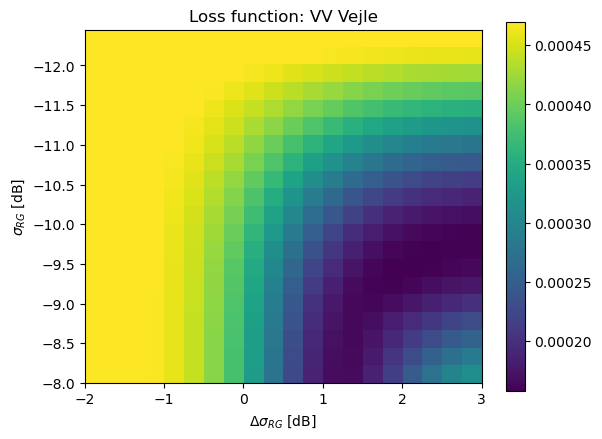

In [23]:
file_path = joinpath(figure_folder,"VV_loss_function.png")
PyPlot.figure(0.001)
PyPlot.imshow(loss,vmin=0.000158,vmax=0.00047
    ,extent=[test_dsigma[1],test_dsigma[end],test_sigma[end],test_sigma[1]])
PyPlot.xlabel("\$\\Delta \\sigma_{RG} \$ [dB]")
PyPlot.ylabel("\$\\sigma_{RG} \$ [dB]")
PyPlot.colorbar()
PyPlot.title("Loss function: VV Vejle")
PyPlot.savefig(file_path)

In [150]:
y_seed =-15
rg_thresholds = [-14,-1]
seed_mask = flood_band .< y_seed;

2-element Array{Int64,1}:
 -14
  -1

In [151]:
rg_mask = (flood_band .<rg_thresholds[1]) .& (change_band.<rg_thresholds[2]) .| seed_mask 
flood_mask, steps = region_growing(seed_mask,rg_mask);

In [152]:
# select the water pixelss in the selected tiles
data = reshape(flood_band,:)[reshape(rg_mask.&bm_mask,:)];
    
# Compare histogram with the emepircal in p_water
h = StatsBase.fit(StatsBase.Histogram, data,edges)
w_sel = h.weights./w_sum;

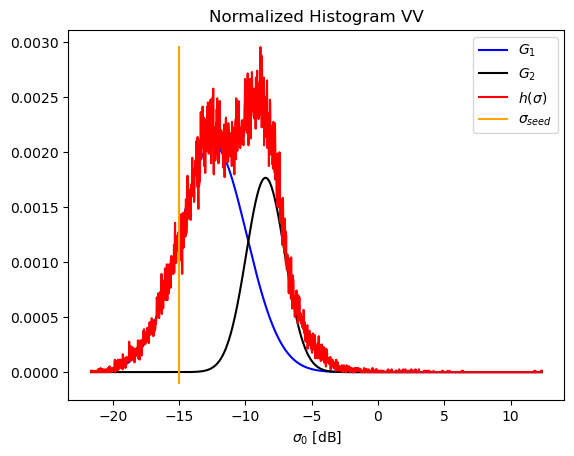

In [153]:
file_path = joinpath(figure_folder,"VV_histogram_tiles_tuned.png")
PyPlot.figure()

PyPlot.plot(y,gauss_model(y,p_fit[[1,3,5]]),color="b")
PyPlot.plot(y,gauss_model(y,p_fit[[2,4,6]]),color="k")
PyPlot.plot(y,w,color="r")
PyPlot.plot(ones(8)*(y_seed),LinRange(minimum(w)-0.0001,maximum(w),8),color="orange")

PyPlot.xlabel("\$\\sigma_0 \$ [dB]")
PyPlot.title("Normalized Histogram VV")
PyPlot.legend(["\$ G_1 \$","\$ G_2 \$","\$ h(\\sigma) \$","\$\\sigma_{seed} \$"])

PyPlot.savefig(file_path)

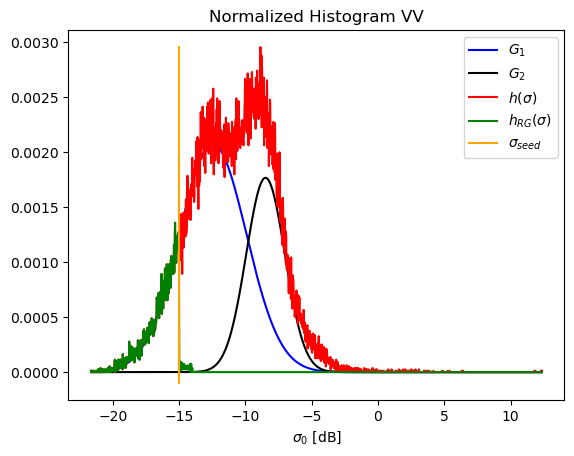

In [154]:
file_path = joinpath(figure_folder,"VV_histogram_flood_tuned.png")
PyPlot.figure()

PyPlot.plot(y,gauss_model(y,p_fit[[1,3,5]]),color="b")
PyPlot.plot(y,gauss_model(y,p_fit[[2,4,6]]),color="k")
PyPlot.plot(y,w,color="r")
PyPlot.plot(y,w_sel,color="g")
PyPlot.plot(ones(8)*(y_seed),LinRange(minimum(w)-0.0001,maximum(w),8),color="orange")

PyPlot.xlabel("\$\\sigma_0 \$ [dB]")
PyPlot.title("Normalized Histogram VV")
PyPlot.legend(["\$ G_1 \$","\$ G_2 \$","\$ h(\\sigma) \$","\$ h_{RG}(\\sigma) \$" ,"\$\\sigma_{seed} \$"])

PyPlot.savefig(file_path)

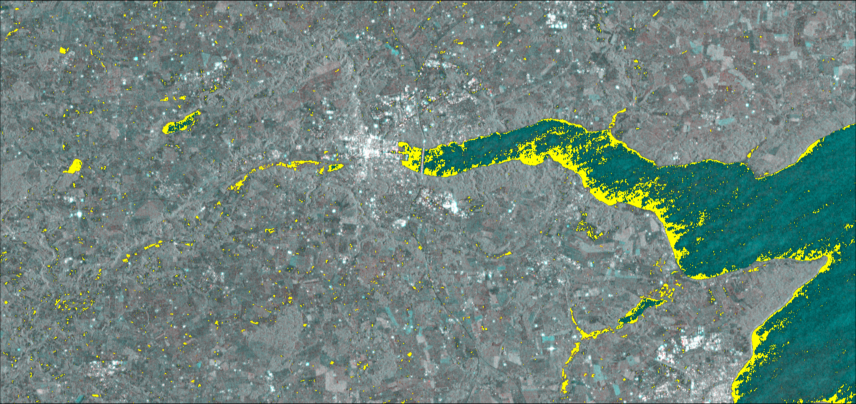

In [155]:
img_save = add_mask(imgVV,flood_mask,(1,1,0))
file_path = joinpath(figure_folder,"VV_flood_noref_tuned")
FileIO.save(file_path*".png",img_save)
img_save

In [156]:
seed_mask_ref = ref_band .<y_seed
rg_mask_ref = (ref_band .<rg_thresholds[1]) .| seed_mask_ref
ref_mask, steps = region_growing(seed_mask_ref,rg_mask_ref);
    
# Remove flase positives and permant water.
final_mask = flood_mask .& (ref_mask .!=true);

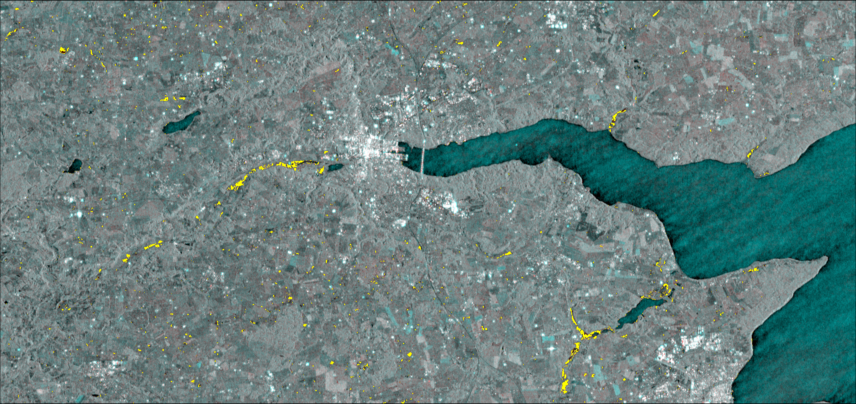

In [157]:
img_save = add_mask(imgVV,final_mask,(1,1,0))

file_path = joinpath(figure_folder,"VV_flood_tuned")
FileIO.save(file_path*".png",img_save)
img_save

In [160]:
file_path = joinpath(data_folder,"VVhand_tuned_mask")
JLD.save(file_path*".jld", "data", final_mask)

## VH

In [161]:
co = VH[1][:,end:-1:1]
pre = VH[2][:,end:-1:1];

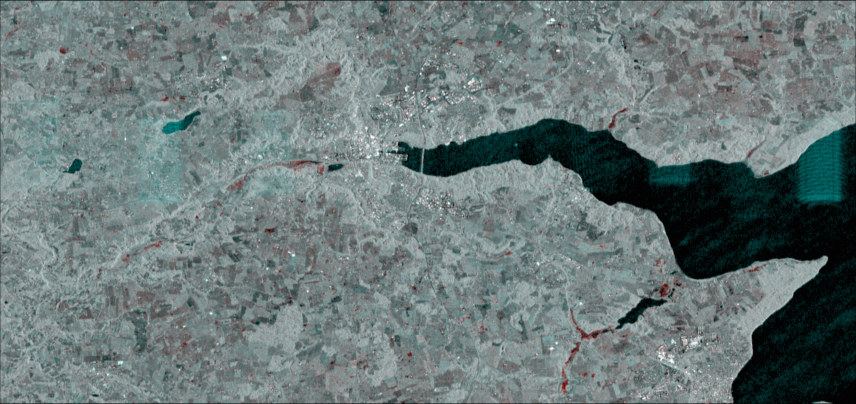

In [162]:
imgVH = pretty_img([co,pre],min_vh,max_vh)

In [163]:
flood_band = 10 .*log10.(co);
ref_band = 10 .*log10.(pre);
change_band = flood_band .- ref_band;

In [164]:
# Find the tiles to fit bimodal
bm_mask_flood = find_bimodal_tiles(flood_band);
bm_mask_change = find_bimodal_tiles(change_band);
bm_mask = bm_mask_change.&bm_mask_flood;


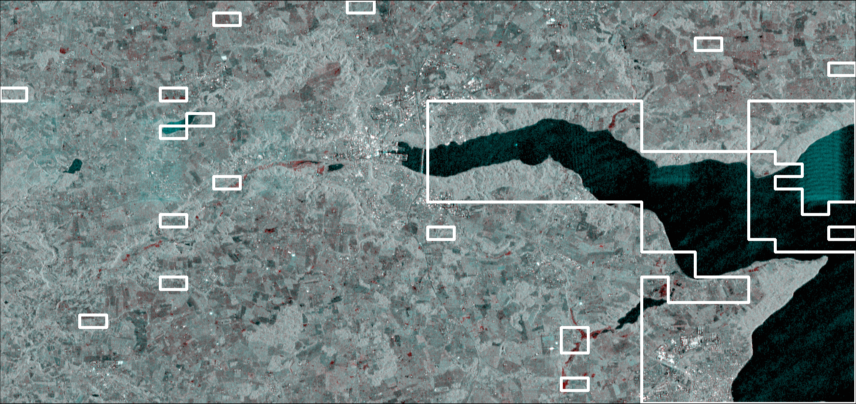

In [165]:
subset_edges = get_edges(bm_mask);
img_save = add_mask(imgVH,subset_edges,(1,1,1))

file_path = joinpath(figure_folder,"VH_tile_select_median")
FileIO.save(file_path*".png",img_save)
img_save

In [166]:
# fit bimodel
data = reshape(flood_band,:)[reshape(bm_mask,:)]
p_fit,y,w,edges, w_sum = fit_bimodal_gauss(data,round(Int64,length(data)/50))

# Find seed pixels
y_seed =find_y_seed(p_fit,y)
seed_mask = flood_band .<y_seed;


In [37]:
t_0 = [y_seed+1, -1]
thresholds3, n_iter = grad_decent(
            (t1,t2) -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [t1,t2])
            ,t_0,debug=true)
f3 = sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds3);


Iterration : 1
x_i: [-23.455, -1.0], f_i: 3.6932947575449006e-5
dfdx: [0.0, 0.0]

Iterration : 2
x_i: [-23.455, -1.0], f_i: 3.6932947575449006e-5
dfdx: [0.0, 0.0]

Iterration : 3
x_i: [-23.455, -1.0], f_i: 3.6932947575449006e-5
dfdx: [-7.991937651800791e-7, -8.194711306557487e-8]
Step x, step_idx:5,  no_step: -2

Iterration : 4
x_i: [-22.65580623481992, -0.9180528869344251], f_i: 3.661248574410991e-5
dfdx: [-1.3115820364879906e-7, -2.7530707125684285e-7]
Step x, step_idx:5,  no_step: -2

Iterration : 5
x_i: [-22.52464803117112, -0.6427458156775823], f_i: 3.652409979843238e-5
dfdx: [-1.9690729398976796e-7, -3.137670646278481e-7]
Step x, step_idx:5,  no_step: -2

Iterration : 6
x_i: [-22.327740737181355, -0.3289787510497342], f_i: 3.6398881229334905e-5
dfdx: [3.312933186011623e-8, -1.7766105156702525e-6]
Step x, step_idx:5,  no_step: -2
Max Iter reached:  region_growing()

Iterration : 7
x_i: [-22.36087006904147, 1.4476317646205183], f_i: 3.565170467623124e-5
dfdx: [4.654285121125263e-6

In [38]:
thresholds3, f3

([-22.26413403169221, 1.449431283564924], 3.5649803796986975e-5)

In [39]:
t_0 = [y_seed+1, -1]
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, t), 
    t_0; autodiff = :forward,store_trace = true,trace_simplex=true)
thresholds1 = res.minimizer
f1 = sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds1)
thresholds1, f1

([-17.603749999999998, -1.296875], 3.6856275342567954e-5)

In [40]:
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [t,10]),
    y_seed, p_fit[4])

y_RG = res.minimizer
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [y_RG,t]),
    -5, 2)
thresholds2 = [y_RG, res.minimizer]
f2 = sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds2)
thresholds2, f2

Max Iter reached:  region_growing()


([-22.885481443403304, 1.9782606952082171], 3.5460616813568526e-5)

In [41]:
rg_thresholds = [thresholds1,thresholds2,thresholds3][threshold_indx];

In [42]:
folder_names_path = joinpath(figure_folder,"thresholds_parameters_VH.txt")   
open(folder_names_path, "w") do io
    write(io, "opt_mul, $(thresholds1[1]), $(thresholds1[2]), $f1 \n")
    write(io, "opt_uni, $(thresholds2[1]), $(thresholds2[2]), $f2 \n")
    write(io, "opt_own, $(thresholds3[1]), $(thresholds3[2]), $f3 \n")
end;

In [43]:
test_sigma = collect(LinRange(y_seed,-14,20))
test_dsigma = collect(LinRange(-2,3,20))
@time loss = [sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [r1,r2])
    for r1=test_sigma, r2=test_dsigma];

Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_gr

In [44]:
minimum(loss),maximum(loss)

(3.469004494452481e-5, 0.00022631844567160879)

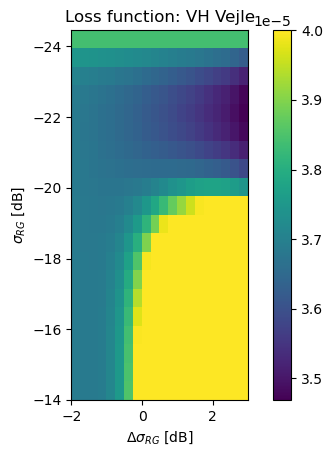

In [51]:
file_path = joinpath(figure_folder,"VH_loss_function.png")
PyPlot.figure(0.001)
PyPlot.imshow(loss,vmin=0.00003469,vmax= 0.00004
    ,extent=[test_dsigma[1],test_dsigma[end],test_sigma[end],test_sigma[1]])
PyPlot.xlabel("\$\\Delta \\sigma_{RG} \$ [dB]")
PyPlot.ylabel("\$\\sigma_{RG} \$ [dB]")
PyPlot.colorbar()
PyPlot.title("Loss function: VH Vejle")
PyPlot.savefig(file_path)

In [201]:
#y_seed =-15
rg_thresholds = [-21,-1]
seed_mask = flood_band .< y_seed;
y_seed

In [202]:
y_seed

-24.455

In [203]:
rg_mask = (flood_band .<rg_thresholds[1]) .& (change_band.<rg_thresholds[2]) .| seed_mask 
flood_mask, steps = region_growing(seed_mask,rg_mask);

In [204]:
# select the water pixelss in the selected tiles
data = reshape(flood_band,:)[reshape(rg_mask.&bm_mask,:)];
    
# Compare histogram with the emepircal in p_water
h = StatsBase.fit(StatsBase.Histogram, data,edges)
w_sel = h.weights./w_sum;

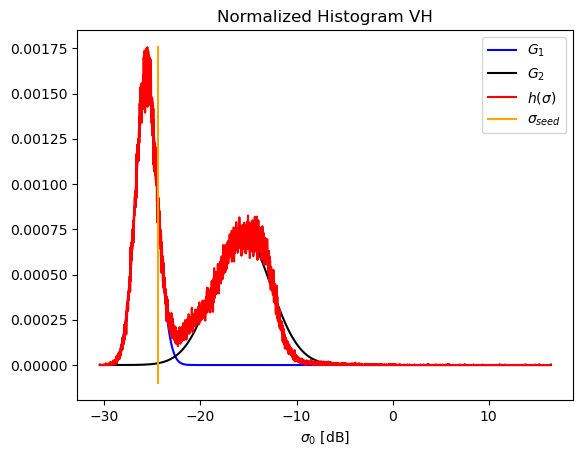

In [205]:
file_path = joinpath(figure_folder,"VH_histogram_tiles_tuned.png")
PyPlot.figure()

PyPlot.plot(y,gauss_model(y,p_fit[[1,3,5]]),color="b")
PyPlot.plot(y,gauss_model(y,p_fit[[2,4,6]]),color="k")
PyPlot.plot(y,w,color="r")
PyPlot.plot(ones(8)*(y_seed),LinRange(minimum(w)-0.0001,maximum(w),8),color="orange")

PyPlot.xlabel("\$\\sigma_0 \$ [dB]")
PyPlot.title("Normalized Histogram VH")
PyPlot.legend(["\$ G_1 \$","\$ G_2 \$","\$ h(\\sigma) \$","\$\\sigma_{seed} \$"])

PyPlot.savefig(file_path)

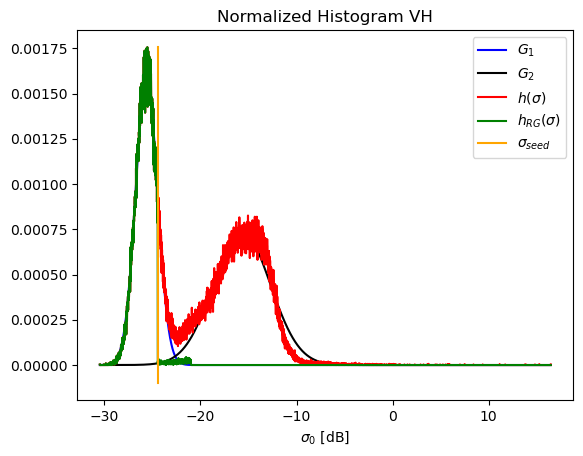

In [206]:
file_path = joinpath(figure_folder,"VH_histogram_flood_tuned.png")
PyPlot.figure()

PyPlot.plot(y,gauss_model(y,p_fit[[1,3,5]]),color="b")
PyPlot.plot(y,gauss_model(y,p_fit[[2,4,6]]),color="k")
PyPlot.plot(y,w,color="r")
PyPlot.plot(y,w_sel,color="g")
PyPlot.plot(ones(8)*(y_seed),LinRange(minimum(w)-0.0001,maximum(w),8),color="orange")

PyPlot.xlabel("\$\\sigma_0 \$ [dB]")
PyPlot.title("Normalized Histogram VH")
PyPlot.legend(["\$ G_1 \$","\$ G_2 \$","\$ h(\\sigma) \$","\$ h_{RG}(\\sigma) \$" ,"\$\\sigma_{seed} \$"])

PyPlot.savefig(file_path)

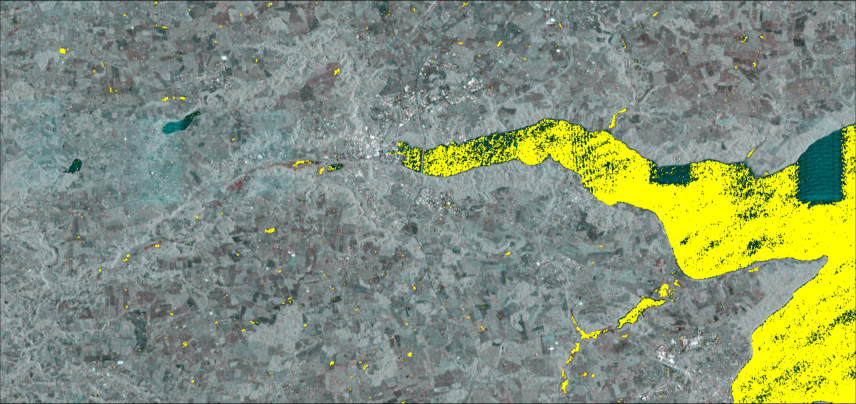

In [207]:
img_save = add_mask(imgVH,flood_mask,(1,1,0))
file_path = joinpath(figure_folder,"VH_flood_noref")
FileIO.save(file_path*".png",img_save)
img_save

In [208]:
seed_mask_ref = ref_band .<y_seed
rg_mask_ref = (ref_band .<rg_thresholds[1]) .| seed_mask_ref
ref_mask, steps = region_growing(seed_mask_ref,rg_mask_ref);
    
# Remove flase positives and permant water.
final_mask = flood_mask .& (ref_mask .!=true);

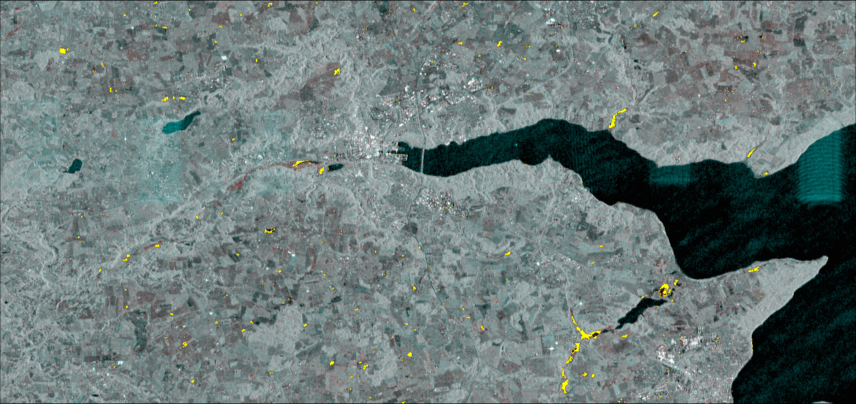

In [209]:
img_save = add_mask(imgVH,final_mask,(1,1,0))

file_path = joinpath(figure_folder,"VH_flood")
FileIO.save(file_path*".png",img_save)
img_save

In [210]:
file_path = joinpath(data_folder,"VHhand_tuned_mask")
JLD.save(file_path*".jld", "data", final_mask)